In [1]:
import pandas as pd
import numpy as np
import os
import warnings

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, PredictionErrorDisplay, make_scorer
from sklearn.exceptions import ConvergenceWarning
from sklearn.cross_decomposition import PLSRegression

import shap
import matplotlib.pyplot as plt

#### Reading in the data

In [2]:
data = pd.read_excel("DataFrame_PathLen.xlsx", index_col=0)

In [3]:
start_columns = data.columns[:2]
end_columns = data.columns[-8:]
data = data.drop(columns=end_columns)
reversed_columns = list(data.columns[2:][::-1])
data = pd.concat([data[start_columns], data[reversed_columns]], axis=1)
data.head()

,Concentration,PathLength,1014.08,1015.85,1017.62,1019.4,1021.19,1022.98,1024.77,1026.58,...,2481.26,2491.87,2502.56,2513.35,2524.23,2535.2,2546.27,2557.44,2568.71,2580.07
0,0.0,2,-0.003896,-0.043464,-0.091262,-0.126840,-0.174819,-0.192862,-0.192901,-0.168534,...,0.000858,-0.003229,0.001830,0.007862,0.003451,0.011817,0.018702,0.033711,0.026110,0.014146
1,0.0,2,-0.130592,-0.122558,-0.086395,-0.036534,-0.036382,-0.019910,0.024605,0.034619,...,-0.017430,-0.021178,-0.030721,-0.039141,-0.056606,-0.072322,-0.078533,-0.088545,-0.079875,-0.070739
2,0.0,2,-0.192816,-0.207047,-0.184241,-0.225598,-0.227852,-0.197358,-0.183834,-0.142657,...,-0.022524,-0.032900,-0.028678,-0.041455,-0.035977,-0.027700,-0.015369,-0.000157,-0.006125,-0.003798
3,0.0,2,0.046772,0.014982,0.012843,-0.007895,-0.037800,-0.041366,-0.037548,-0.042814,...,0.017800,0.034230,0.041803,0.038687,0.035627,0.024114,0.008796,-0.009463,-0.015533,-0.035467
4,0.0,2,-0.006319,-0.052606,-0.072452,-0.073160,-0.079192,-0.075099,-0.044482,-0.036838,...,0.054001,0.034155,0.024236,0.021352,0.015860,0.023178,0.022523,0.036191,0.051858,0.061045


#### Organising it unto the subsets based on pathlength

In [4]:
data_2 = data[data['PathLength'] == 2]
data_5 = data[data['PathLength'] == 5]
data_10 = data[data['PathLength'] == 10]

#### Visualisation of our Average intensity by path length

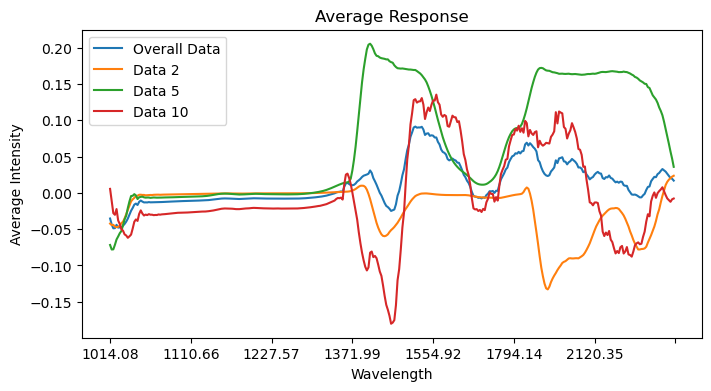

In [5]:
# Calculating the mean of the wavelength feature columns for each DataFrame
avg_spectrum_ovrll = data.iloc[:, 2:].mean()
avg_spectrum_2 = data_2.iloc[:, 2:].mean()
avg_spectrum_5 = data_5.iloc[:, 2:].mean()
avg_spectrum_10 = data_10.iloc[:, 2:].mean()

plt.figure(figsize=(8, 4))

avg_spectrum_ovrll.plot(label='Overall Data')
avg_spectrum_2.plot(label='Data 2')
avg_spectrum_5.plot(label='Data 5')
avg_spectrum_10.plot(label='Data 10')

plt.title('Average Response')
plt.xlabel('Wavelength')
plt.ylabel('Average Intensity')

plt.legend()

plt.show()

## Undersampled data
This is the methodology to ensure an even distrubution of sdamples across path lengths

In [6]:
# Filter and sample rows from the dataset where Path Length is 2 and Concentration is 0
remove_from_2_0 = data.loc[(data['PathLength'] == 2) & (data['Concentration'] == 0)].sample(24, random_state=4)

# Filter and sample rows from the dataset where Path Length is 5 and Concentration is 0
remove_from_5_0 = data.loc[(data['PathLength'] == 5) & (data['Concentration'] == 0)].sample(7, random_state=4)

# Filter and sample rows from the dataset where Path Length is 2 and Concentration is 1.3
remove_from_2_1 = data.loc[(data['PathLength'] == 2) & (data['Concentration'] == 1.3)].sample(72, random_state=4)

# Filter and sample rows from the dataset where Path Length is 10 and Concentration is 1.3
remove_from_10_1 = data.loc[(data['PathLength'] == 10) & (data['Concentration'] == 1.3)].sample(45, random_state=4)

removals = [remove_from_2_0,remove_from_5_0,remove_from_2_1,remove_from_10_1]
removals_df = pd.concat(removals)

In [7]:
# Dropping rows specified in removals_df from the original dataset to create an undersampled dataset
undersampled_data = data.drop(removals_df.index)

# Filtering the undersampled dataset to get entries by Path Length
undersampled_data_2 = undersampled_data[undersampled_data['PathLength'] == 2]
undersampled_data_5 = undersampled_data[undersampled_data['PathLength'] == 5]
undersampled_data_10 = undersampled_data[undersampled_data['PathLength'] == 10]

# Printing the count of entries for each Path Length after undersampling
print(len(undersampled_data_2),len(undersampled_data_2),len(undersampled_data_10))
# Printing the count of entries for each Path Length before any removals for comparison
print(len(data_2),len(data_5),len(data_10))

print(len(undersampled_data_2) + len(undersampled_data_5) + len(undersampled_data_10))
print(len(data_2) + len(data_5) + len(data_10))


349 349 349
445 356 394
1047
1195


## Functions for modelling

In [8]:
def plot_observed_vs_predicted(y_true, y_pred, column_name):
    plt.figure(figsize=(7, 7))
    # Creating a scatter plot of actual vs. predicted values with partial transparency
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel(f'Actual {column_name}')
    plt.ylabel(f'Predicted {column_name}')
    plt.title(f'Observed vs. Predicted for {column_name}')
    plt.grid(True)

    # Determining the maximum value found in either the actual or predicted data
    max_value = max(y_true.max(), y_pred.max())
    # Drawing a line from (0,0) to (max_value, max_value) to show the line of perfect prediction
    plt.plot([0, max_value], [0, max_value], linestyle='--', color='red')
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    plt.savefig('plots/Observed_vs_predicted')

Cross-validated grid search to hyper-parameterise number of components in PLS

In [9]:
def grid_search_pls(data, k=10, n_components_range=None):
    X = data[data.columns[2:]]
    y = data['Concentration']

    # Define range for n_components if not provided
    if n_components_range is None:
        n_components_range = list(range(1, min(X.shape[1], 15) + 1))  # 1 to 15 or number of features

    # Define PLS model and parameter grid
    pls = PLSRegression()
    param_grid = {'n_components': n_components_range}

    # Define scorer and grid search
    scorer = make_scorer(r2_score)
    grid_search = GridSearchCV(pls, param_grid, cv=k, scoring=scorer, n_jobs=-1)

    # Fit grid search
    grid_search.fit(X, y)

    print("Best Parameters:")
    print(grid_search.best_params_)
    print(f"Best R2 Score: {grid_search.best_score_:.4f}")

    return grid_search.best_params_

In [10]:
def pls(data, n_components=14, k=10, graph=False):
    X = data[data.columns[2:]]
    kf = KFold(n_splits=k, shuffle=True, random_state=4)
    r2_scores = {}
    rmse_scores = {}
    mae_scores = {}
    column = 'Concentration'

    y = data[column]
    
    # Initialise empty lists to collect scores for the target column
    r2_scores[column] = []
    rmse_scores[column] = []
    mae_scores[column] = []

    # Loop through each fold in k-fold cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardise features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit PLS model
        model = PLSRegression(n_components=n_components)
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_scaled).ravel()

        # Metrics for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scores[column].append(r2)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores[column].append(rmse)

        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[column].append(mae)

    # Plot last fold results if graph is True
    if graph:
        plot_observed_vs_predicted(y_test, y_pred, column)

    # Compute and display average metrics
    r2_scores[column] = sum(r2_scores[column]) / len(r2_scores[column])
    rmse_scores[column] = sum(rmse_scores[column]) / len(rmse_scores[column])
    mae_scores[column] = sum(mae_scores[column]) / len(mae_scores[column])

    print("Average Evaluation Metrics:")
    print(f"Column: {column}")
    print(f"R2 Score: {r2_scores[column]:.4f}")
    print(f"RMSE: {rmse_scores[column]:.4f}")
    print(f"MAE: {mae_scores[column]:.4f}")
    print('-' * 30)

In [11]:
dataframes = {
    "All Path Lengths": undersampled_data,
    "Path Length 2": undersampled_data_2,
    "Path Length 5": undersampled_data_5,
    "Path Length 10": undersampled_data_10
}
for name,df in dataframes.items():
    print(str(name))
    best_params = grid_search_pls(df)
    optimal_components = best_params['n_components']

    # Use this optimal number of components in your PLS model
    pls(df, k=10, graph=False, n_components=optimal_components)

All Path Lengths
Best Parameters:
{'n_components': 3}
Best R2 Score: -1397.1943
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.6343
RMSE: 336.5041
MAE: 285.2658
------------------------------
Path Length 2
Best Parameters:
{'n_components': 15}
Best R2 Score: -109.8127
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9993
RMSE: 14.0501
MAE: 10.8057
------------------------------
Path Length 5
Best Parameters:
{'n_components': 11}
Best R2 Score: -265.0406
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9939
RMSE: 35.2465
MAE: 24.2109
------------------------------
Path Length 10
Best Parameters:
{'n_components': 15}
Best R2 Score: -921.4749
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9951
RMSE: 38.6471
MAE: 30.9928
------------------------------


In [12]:
def lasso(data, k=10, graph=False):
    X = data[data.columns[2:]]
    kf = KFold(n_splits=k, shuffle=True, random_state=4)
    r2_scores = {}
    rmse_scores = {}
    mae_scores = {}
    column = 'Concentration'

    y = data[column]
    
    # Initialise empty lists to collect scores for the target column
    r2_scores[column] = []
    rmse_scores[column] = []
    mae_scores[column] = []

    
    # Iterating over each fold specified by KFold.
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardise features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Cleaner output
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        
        # Fit LASSO model
        model = Lasso(random_state=4)
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)

        # Metrics for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scores[column].append(r2)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores[column].append(rmse)

        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[column].append(mae)

    # Plot last fold results if graph is True
    if graph == True:
        plot_observed_vs_predicted(y_test, y_pred, column)

        
    # Compute and display average metrics
    r2_scores[column] = sum(r2_scores[column]) / len(r2_scores[column])
    rmse_scores[column] = sum(rmse_scores[column]) / len(rmse_scores[column])
    mae_scores[column] = sum(mae_scores[column]) / len(mae_scores[column])

    print("Average Evaluation Metrics:")
    print(f"Column: {column}")
    print(f"R2 Score: {r2_scores[column]}")
    print(f"RMSE: {rmse_scores[column]}")
    print(f"MAE: {mae_scores[column]}")
    print('-' * 30)

In [13]:
def rand_forest(data, k=10, graph=False, evaluate_train_err=False):
    X = data[data.columns[2:]]
    y = data['Concentration']
    column = 'Concentration'
    
    # Configuring the k-fold cross-validation setup with shuffling.
    kf = KFold(n_splits=k, shuffle=True, random_state=4) 

    
    # Initialising dictionaries to store performance metrics for testing and optionally for training.
    test_scores = {'r2': [], 'rmse': [], 'mae': []}
    train_scores = {'r2': [], 'rmse': [], 'mae': []} if evaluate_train_err else None

    # Iterating over each fold specified by KFold.
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardising the features to mean zero and unit variance.
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Training the Random Forest model.
        model = RandomForestRegressor(random_state=4, n_jobs=-1)
        model.fit(X_train_scaled, y_train)
        
        # Making predictions and calculating test metrics.
        y_test_pred = model.predict(X_test_scaled)
        test_scores['r2'].append(r2_score(y_test, y_test_pred))
        test_scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        test_scores['mae'].append(mean_absolute_error(y_test, y_test_pred))
        
        # Optionally calculating training metrics if required.
        if evaluate_train_err:
            y_train_pred = model.predict(X_train_scaled)
            train_scores['r2'].append(r2_score(y_train, y_train_pred))
            train_scores['rmse'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            train_scores['mae'].append(mean_absolute_error(y_train, y_train_pred))

    # If training error evaluation is enabled, visualising the comparison between train and test metrics.
    if evaluate_train_err:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        metric_titles = ['R2 Scores', 'RMSE', 'MAE']
        for i, metric in enumerate(['r2', 'rmse', 'mae']):
            box = axs[i].boxplot([train_scores[metric], test_scores[metric]], labels=['Train', 'Test'], patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})

            for patch, color in zip(box['boxes'], ['skyblue', 'salmon']):
                patch.set_facecolor(color)

            axs[i].set_title(metric_titles[i])
        plt.suptitle('Comparison of Train and Test Metrics Across Folds')
        plt.show()

    # Optionally plotting the prediction error for the last fold if graphing is enabled.
    if graph:
        plot_observed_vs_predicted(y_test, y_test_pred, column)

    # Printing the average test metrics.
    print(f"Average Test Metrics:")
    for metric in test_scores:
        print(f"{metric.upper()}: {np.mean(test_scores[metric])}")

    # Optionally printing the average training metrics.
    if evaluate_train_err:
        print(f"\nAverage Train Metrics:")
        for metric in train_scores:
            print(f"{metric.upper()}: {np.mean(train_scores[metric])}")

    print('-' * 30)

Running the models on each dataset

In [14]:
dataframes = {
    "All Path Lengths": data,
    "Path Length 2": data_2,
    "Path Length 5": data_5,
    "Path Length 10": data_10
}

# Looping through the dictionary items.
for name,df in dataframes.items():
    print('Dataset: ' + name)
    print('PLS:')
    # 15 is the optimal for Path Length 2, the best performing for PLS
    pls(df, n_components=15)
    print('\n')
    
    print('Dataset: ' + name)
    print('Random Forest:')
    rand_forest(df)
    print('\n')
    
    print('Dataset: ' + name)
    print('Lasso:')
    lasso(df)
    print('\n')

Dataset: All Path Lengths
PLS:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.8760
RMSE: 190.9929
MAE: 139.7910
------------------------------


Dataset: All Path Lengths
Random Forest:
Average Test Metrics:
R2: 0.9777081942404872
RMSE: 73.7749476530759
MAE: 16.828383018207283
------------------------------


Dataset: All Path Lengths
Lasso:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.8765515491113142
RMSE: 190.49336499429714
MAE: 139.3515792728486
------------------------------


Dataset: Path Length 2
PLS:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9993
RMSE: 13.0894
MAE: 10.0399
------------------------------


Dataset: Path Length 2
Random Forest:
Average Test Metrics:
R2: 0.9704022118985242
RMSE: 50.999531915131996
MAE: 11.307768333333334
------------------------------


Dataset: Path Length 2
Lasso:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9983730313315915
RMSE: 19.352780465613684
MAE: 13.346256648160438
---

Running the models on each undersampled dataset

In [15]:
dataframes = {
    "All Path Lengths": undersampled_data,
    "Path Length 2": undersampled_data_2,
    "Path Length 5": undersampled_data_5,
    "Path Length 10": undersampled_data_10
}

for name,df in dataframes.items():
    
    print('Dataset: ' + name)
    print('Random Forest:')
    rand_forest(df)
    print('\n')
    
    print('Dataset: ' + name)
    print('Lasso:')
    lasso(df)
    print('\n')
    
    print('Dataset: ' + name)
    print('PLS:')
    # 15 is the optimal for Path Length 2, the best performing for PLS
    pls(df, n_components=15)
    print('\n')

Dataset: All Path Lengths
Random Forest:
Average Test Metrics:
R2: 0.9778256216295376
RMSE: 76.38419315497308
MAE: 18.8424844047619
------------------------------


Dataset: All Path Lengths
Lasso:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.8746457861770527
RMSE: 196.87893701559182
MAE: 147.46532313443578
------------------------------


Dataset: All Path Lengths
PLS:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.8730
RMSE: 198.1569
MAE: 148.2100
------------------------------


Dataset: Path Length 2
Random Forest:
Average Test Metrics:
R2: 0.9697325170153487
RMSE: 65.04790570714624
MAE: 14.233615882352941
------------------------------


Dataset: Path Length 2
Lasso:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9987727316185904
RMSE: 18.550953480230202
MAE: 13.428700334249317
------------------------------


Dataset: Path Length 2
PLS:
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9993
RMSE: 14.0501
MAE: 10.8057
----

| **Dataset**         | **Model**          | **R² Score**      | **RMSE**       | **MAE**       |
|----------------------|--------------------|-------------------|----------------|---------------|
| **All Path Lengths** | **Random Forest** | **0.9778**        | **76.38**      | **18.84**     |
|                      | LASSO             | 0.8746            | 196.88         | 147.47        |
|                      | PLS               | 0.8730            | 198.16         | 148.21        |
| **Path Length 2**    | Random Forest     | 0.9697            | 65.05          | 14.23         |
|                      | LASSO             | 0.9988            | 18.55          | 13.43         |
|                      | **PLS**           | **0.9993**        | **14.05**      | **10.81**     |
| **Path Length 5**    | **Random Forest** | **0.9977**        | **18.96**      | **4.87**      |
|                      | LASSO             | 0.9948            | 35.12          | 25.51         |
|                      | PLS               | 0.9938            | 34.47          | 23.00         |
| **Path Length 10**   | **Random Forest** | **0.9986**        | **15.93**      | **3.97**      |
|                      | LASSO             | 0.9958            | 35.91          | 28.07         |
|                      | PLS               | 0.9951            | 38.65          | 30.99         |

### This is the feature selection Methodology

In [16]:
def iterative_feature_removal(df, final_feature_count=1, filename='feature_removal_metrics.png'):
    X = df.iloc[:, 2:]
    y = df['Concentration']
    
    # Dictionary to hold metrics for each iteration
    metrics = {
        'Train R2': [], 'Train MAE': [], 'Train RMSE': [],
        'Test R2': [], 'Test MAE': [], 'Test RMSE': [],
        'Features': []
    }
    # List of all features in the dataset
    features = X.columns.tolist()
    
    # Parameters for feature reduction
    initial_reduction_factor = 0.2 # Initial percentage of features to remove each iteration
    refinement_threshold = 20 # When the number of features drops below this, reduce one at a time

    # KFold setup for cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=4)
    
    # Variables to track the best model
    best_r2 = -np.inf
    best_features = None
    iteration = 0
    
    # Iteratively reduce features until the count reaches final_feature_count
    while len(features) > final_feature_count:
        # Lists to store metrics for each fold
        train_r2_scores = []
        train_mae_scores = []
        train_rmse_scores = []
        test_r2_scores = []
        test_mae_scores = []
        test_rmse_scores = []

        # Cross-validation loop
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[features].iloc[train_index], X[features].iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Training the Random Forest model
            model = RandomForestRegressor(n_estimators=100, random_state=4, n_jobs=-1)
            model.fit(X_train, y_train)
            
            # Predicting and computing metrics for both train and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_r2_scores.append(r2_score(y_train, y_train_pred))
            train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
            train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

            test_r2_scores.append(r2_score(y_test, y_test_pred))
            test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
            test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        # Calculating average metrics for the current set of features
        average_test_r2 = np.mean(test_r2_scores)
        metrics['Train R2'].append(np.mean(train_r2_scores))
        metrics['Train MAE'].append(np.mean(train_mae_scores))
        metrics['Train RMSE'].append(np.mean(train_rmse_scores))
        metrics['Test R2'].append(average_test_r2)
        metrics['Test MAE'].append(np.mean(test_mae_scores))
        metrics['Test RMSE'].append(np.mean(test_rmse_scores))
        metrics['Features'].append(len(features))
        
        # Update the best model if the current one is better
        if average_test_r2 > best_r2:
            best_r2 = average_test_r2
            best_features = features.copy()

        # Refitting to get feature importances
        model.fit(X[features], y)
        importances = model.feature_importances_
        feature_importance_dict = {feature: imp for feature, imp in zip(features, importances)}
        sorted_features = sorted(feature_importance_dict, key=feature_importance_dict.get)
        
        # Determining how many features to remove
        if len(features) > refinement_threshold:
            features_to_remove_count = max(int(len(features) * initial_reduction_factor), 1)
        else:
            features_to_remove_count = 1
        
        # Updating the feature list by removing the least important features
        features = [f for f in features if f not in sorted_features[:features_to_remove_count]]
        iteration += 1
    
    # Plotting metrics across iterations
    iterations = list(range(1, iteration + 1))
    metric_types = ['R2', 'MAE', 'RMSE']
    for i, metric in enumerate(metric_types):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(iterations, metrics[f'Train {metric}'], label=f'Train {metric}', marker='o', linestyle='-', color='blue')
        ax.plot(iterations, metrics[f'Test {metric}'], label=f'Test {metric}', marker='s', linestyle='--', color='green')
        ax.set_xticks(iterations)
        ax.set_xticklabels(metrics['Features'], rotation=45)
        ax.set_xlabel('Number of Features')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Over Iterations')
        ax.legend()
        # Inverting x axis to show in decreasing order of feature count
        ax.invert_xaxis()

        # Saving each metric's plot separately
        plt.tight_layout()
        
        if not os.path.exists('plots'):
            os.makedirs('plots')
            
        plt.savefig(f'plots/{metric}_{filename}', dpi=300)
        plt.close(fig)
    
    # Printing the best performing features and corresponding R2 score
    print(best_features, best_r2)

In [17]:
dataframes = {
    "Overall Data": undersampled_data,
    "Path Length 2": undersampled_data_2,
    "Path Length 5": undersampled_data_5,
    "Path Length 10": undersampled_data_10
}

for name, df in dataframes.items():
    print('Database: ' + name)
    iterative_feature_removal(df, filename=name)
    print('\n')

Database: Overall Data
[1108.55, 1310.33, 1313.28, 1316.25, 1337.38, 1340.45, 1343.54, 1346.64, 1349.76, 1359.2, 1362.38, 1398.31, 1439.75, 1680.39, 1690.14, 1699.99, 1714.99, 2105.04, 2120.35, 2313.88, 2491.87] 0.9829153112288307


Database: Path Length 2
[1391.64, 1394.97, 1398.31, 1401.68, 1408.45, 1411.86, 2135.89, 2143.74, 2151.65, 2159.62, 2167.65, 2175.73] 0.9718458950139176


Database: Path Length 5
[1278.72, 1281.53, 1284.35, 1295.77, 1325.22, 1331.27, 1334.32, 1337.38, 1343.54, 1346.64, 1349.76, 1362.38, 1371.99, 1695.05] 0.9995556540391201


Database: Path Length 10
[1121.34, 1340.45, 1343.54, 1346.64, 1362.38, 1502.83, 1510.61, 1514.54, 1518.48, 1522.45, 1530.44, 1534.47, 1542.58, 1546.68, 1550.79, 1554.92, 1567.46, 1571.69, 1575.94, 1580.21, 1588.82, 1601.91, 1606.33, 1610.76, 1615.23, 1619.71] 0.9989912715431559




In [18]:
top_features_undersampled_2 = ['1391.64', '1394.97', '1398.31', '1401.68', '1408.45', '1411.86', '2135.89', '2143.74', '2151.65', '2159.62', '2167.65', '2175.73']
top_features_undersampled_5 = ['1278.72', '1281.53', '1284.35', '1295.77', '1325.22', '1331.27', '1334.32', '1337.38', '1343.54', '1346.64', '1349.76', '1362.38', '1371.99', '1695.05']
top_features_undersampled_10 = ['1121.34', '1340.45', '1343.54', '1346.64', '1362.38', '1502.83', '1510.61', '1514.54', '1518.48', '1522.45', '1530.44', '1534.47', '1542.58', '1546.68', '1550.79', '1554.92', '1567.46', '1571.69', '1575.94', '1580.21', '1588.82', '1601.91', '1606.33', '1610.76', '1615.23', '1619.71']

top_features_undersampled_2 = [float(col) for col in top_features_undersampled_2]
top_features_undersampled_5 = [float(col) for col in top_features_undersampled_5]
top_features_undersampled_10 = [float(col) for col in top_features_undersampled_10]

print(len(top_features_undersampled_2),len(top_features_undersampled_5),len(top_features_undersampled_10))
start_columns = ['Concentration', 'PathLength']
features_list_undersampled_2 = start_columns + top_features_undersampled_2
features_list_undersampled_5 = start_columns + top_features_undersampled_5
features_list_undersampled_10 = start_columns + top_features_undersampled_10

undersampled_data_2_top_features = undersampled_data_2[features_list_undersampled_2]
undersampled_data_5_top_features = undersampled_data_5[features_list_undersampled_5]
undersampled_data_10_top_features = undersampled_data_10[features_list_undersampled_10]

12 14 26


In [19]:
rand_forest(undersampled_data_2_top_features)
rand_forest(undersampled_data_5_top_features)
rand_forest(undersampled_data_10_top_features)

Average Test Metrics:
R2: 0.9718458950139176
RMSE: 61.87672432402904
MAE: 12.609582689075634
------------------------------
Average Test Metrics:
R2: 0.9995556540391201
RMSE: 6.214332006940173
MAE: 1.3305205042016808
------------------------------
Average Test Metrics:
R2: 0.9989912715431559
RMSE: 11.307272729398749
MAE: 2.6492721848739507
------------------------------


### Plot of the average intensity with the top features for each Path Length marked

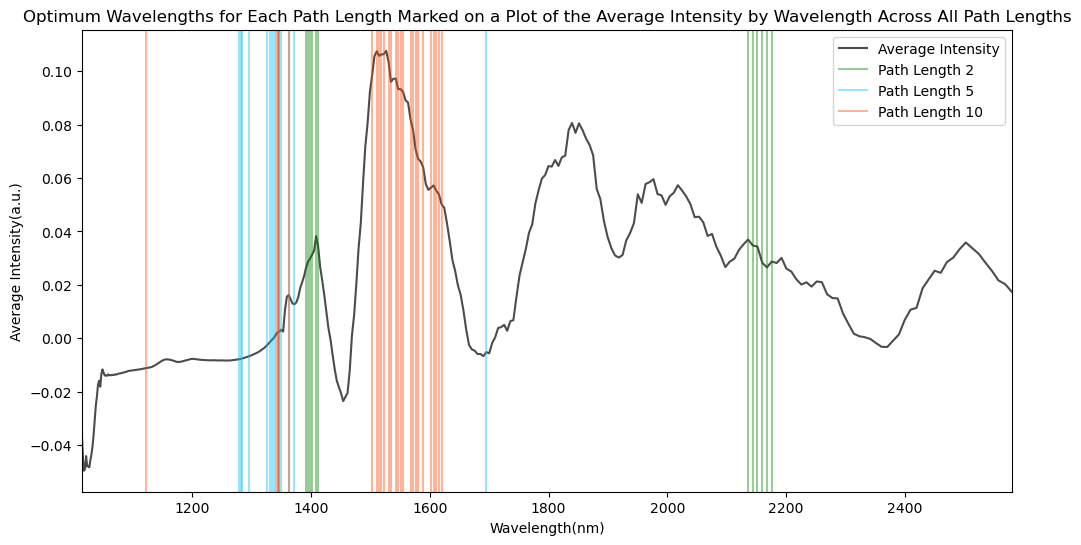

In [20]:
# Calculate the average spectrum from the undersampled data
avg_spectrum = undersampled_data.iloc[:, 2:].mean()
data_features = data.columns[2:]

plt.figure(figsize=(12, 6))

# Define x-axis limits based on the minimum and maximum wavelengths
plt.xlim([min(data_features), max(data_features)])
plt.plot(avg_spectrum, color='black', alpha=0.7, label='Average Intensity')

# Define colours for each path length set for clarity in visual distinction
colours = ['green','deepskyblue','orangered']

# A list of lists containing top features (wavelengths) for each path length
pathlengths = [top_features_undersampled_2,
               top_features_undersampled_5,
               top_features_undersampled_10]
labels = ['Path Length 2', 'Path Length 5', 'Path Length 10']

# Loop through each set of path lengths
for idx, features in enumerate(pathlengths):
    # Mark each feature with a vertical line
    for wavelength in features:
        plt.axvline(x=float(wavelength), color=colours[idx], linestyle='-', alpha=0.4, 
                    label=labels[idx] if features.index(wavelength) == 0 else "")

plt.title('Optimum Wavelengths for Each Path Length Marked on a Plot of the Average Intensity by Wavelength Across All Path Lengths')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Average Intensity(a.u.)')
plt.legend()

if not os.path.exists('plots'):
    os.makedirs('plots')
    
plt.savefig('plots/average_intensity_plot_all_pathlengths.png', format='png', dpi=600)

## Errors at each concentration

In [21]:
def evaluate_levels(y_true, y_pred, levels):
    # Initialise a dictionary to store error metrics and errors for each level.
    level_data = {level: {'mae': 0, 'rmse': 0, 'errors': {'mae': [], 'rmse': []}} for level in levels}
    
    # Loop through each specified level to compute metrics.
    for level in levels:
        # Identify the indices where the true values match the current level.
        indices = (y_true == level)
        y_true_level = y_true[indices]
        y_pred_level = y_pred[indices]

        # Calculate absolute errors and squared errors.
        abs_errors = np.abs(y_true_level - y_pred_level)
        sq_errors = (y_true_level - y_pred_level) ** 2

        level_data[level]['errors']['mae'] = abs_errors
        level_data[level]['errors']['rmse'] = sq_errors

        # Compute the mean absolute error and root mean squared error.
        level_data[level]['mae'] = np.mean(abs_errors)
        level_data[level]['rmse'] = np.sqrt(np.mean(sq_errors))
    
    return level_data

In [22]:
def plot_error_distributions(level_data):
    # Determine the number of levels to set the number of subplots
    num_levels = len(level_data)
    # Creating a subplot grid: one row for each level and two columns for MAE and RMSE
    fig, axs = plt.subplots(num_levels, 2, figsize=(12, num_levels * 3), squeeze=False)

    # Looping through each level to plot its error distributions
    for i, (level, data) in enumerate(level_data.items()):
        # Extracting MAE and RMSE errors from the data
        mae_errors = data['mae']
        rmse_errors = data['rmse']

        mae_bins = 30
        rmse_bins = 30

        # Plotting the histogram for MAE
        axs[i, 0].hist(mae_errors, bins=mae_bins, color='skyblue', edgecolor='black')
        axs[i, 0].set_title(f"MAE Distribution at Level {level}")
        axs[i, 0].set_xlabel('MAE')
        axs[i, 0].set_ylabel('Frequency')

        # Plotting the histogram for RMSE
        axs[i, 1].hist(rmse_errors, bins=rmse_bins, color='salmon', edgecolor='black')
        axs[i, 1].set_title(f"RMSE Distribution at Level {level}")
        axs[i, 1].set_xlabel('RMSE')
        axs[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [23]:
def rand_forest_levels(data, k=10, importances=False):
    X = data[data.columns[2:]]
    y = data['Concentration']
    kf = KFold(n_splits=k, shuffle=True, random_state=4)    
    test_scores = {'r2': [], 'rmse': [], 'mae': []}
    levels = unique_levels = y.unique()
    aggregated_errors = {level: {'mae': [], 'rmse': []} for level in levels}
    feature_importances = np.zeros(X.shape[1])

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = RandomForestRegressor(random_state=4, n_jobs=-1)
        model.fit(X_train_scaled, y_train)
        
        feature_importances += model.feature_importances_
        
        y_test_pred = model.predict(X_test_scaled)
        test_scores['r2'].append(r2_score(y_test, y_test_pred))
        test_scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        test_scores['mae'].append(mean_absolute_error(y_test, y_test_pred))
        
        # Evaluate performance per level
        fold_metrics_per_level = evaluate_levels(y_test, y_test_pred, levels)
        for level in levels:
            aggregated_errors[level]['mae'].extend(fold_metrics_per_level[level]['errors']['mae'])

            rmse_per_fold = np.sqrt(np.mean(fold_metrics_per_level[level]['errors']['rmse']))
            aggregated_errors[level]['rmse'].append(rmse_per_fold)
        
    # Plot error distributions for each level
    plot_error_distributions(aggregated_errors)
    
    # Average feature importances over all folds
    feature_importances /= k
    
    # Output average test metrics
    print(f"Average Test Metrics:")
    for metric in test_scores:
        print(f"{metric.upper()}: {np.mean(test_scores[metric])}")

    # Output metrics for each level 
    for level in levels:
        if aggregated_errors[level]['mae'] and any(np.isfinite(aggregated_errors[level]['rmse'])):
            print(f"Metrics for Level {level}:")
            avg_mae = np.mean(aggregated_errors[level]['mae'])
            finite_rmse = [value for value in aggregated_errors[level]['rmse'] if np.isfinite(value)]
            avg_rmse = np.mean(finite_rmse) if finite_rmse else float('nan')

            print(f"  RMSE: {avg_rmse}")
            print(f"  MAE: {avg_mae}")
        else:
            print(f"Metrics for Level {level}:")
            print(f"  RMSE: Not available due to insufficient data")
            print(f"  MAE: Not available due to insufficient data")

    # Optionally print top 10 feature importances
    for level in levels:
        if importances:
            feature_names = data.columns[2:]
            importances_data = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
            print("Top 10 Feature Importances:")
            for name, importance in importances_data[:10]:
                print(f"{name}: {importance:.4f}")
            return importances_data

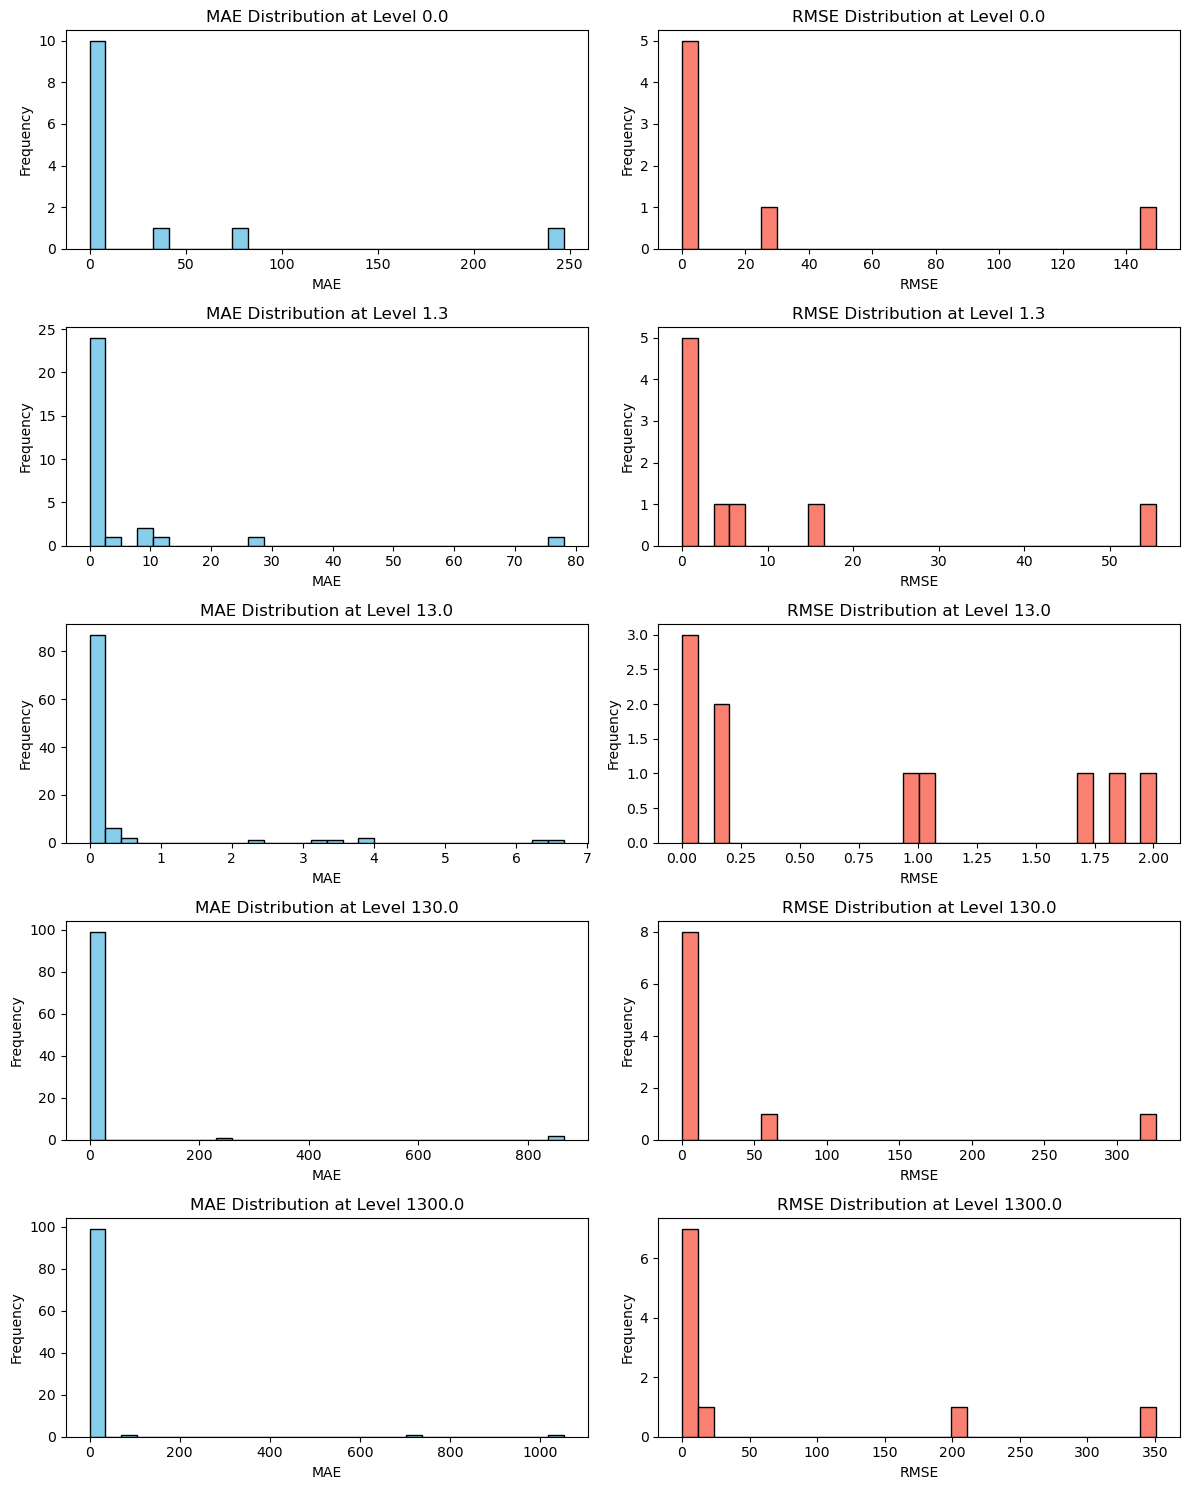

Average Test Metrics:
R2: 0.9718458950139176
RMSE: 61.87672432402904
MAE: 12.609582689075634
Metrics for Level 0.0:
  RMSE: 25.343724015393285
  MAE: 28.039
Metrics for Level 1.3:
  RMSE: 9.205075958106963
  MAE: 4.692133333333335
Metrics for Level 13.0:
  RMSE: 0.7947052454743583
  MAE: 0.3200294117647064
Metrics for Level 130.0:
  RMSE: 39.420879067382614
  MAE: 19.5
Metrics for Level 1300.0:
  RMSE: 58.50437534295579
  MAE: 18.46764705882353
Top 10 Feature Importances:
1398.31: 0.1925
1391.64: 0.1426
1394.97: 0.1279
2167.65: 0.1178
2159.62: 0.0702
2143.74: 0.0691
2175.73: 0.0654
1401.68: 0.0608
1411.86: 0.0558
2151.65: 0.0441


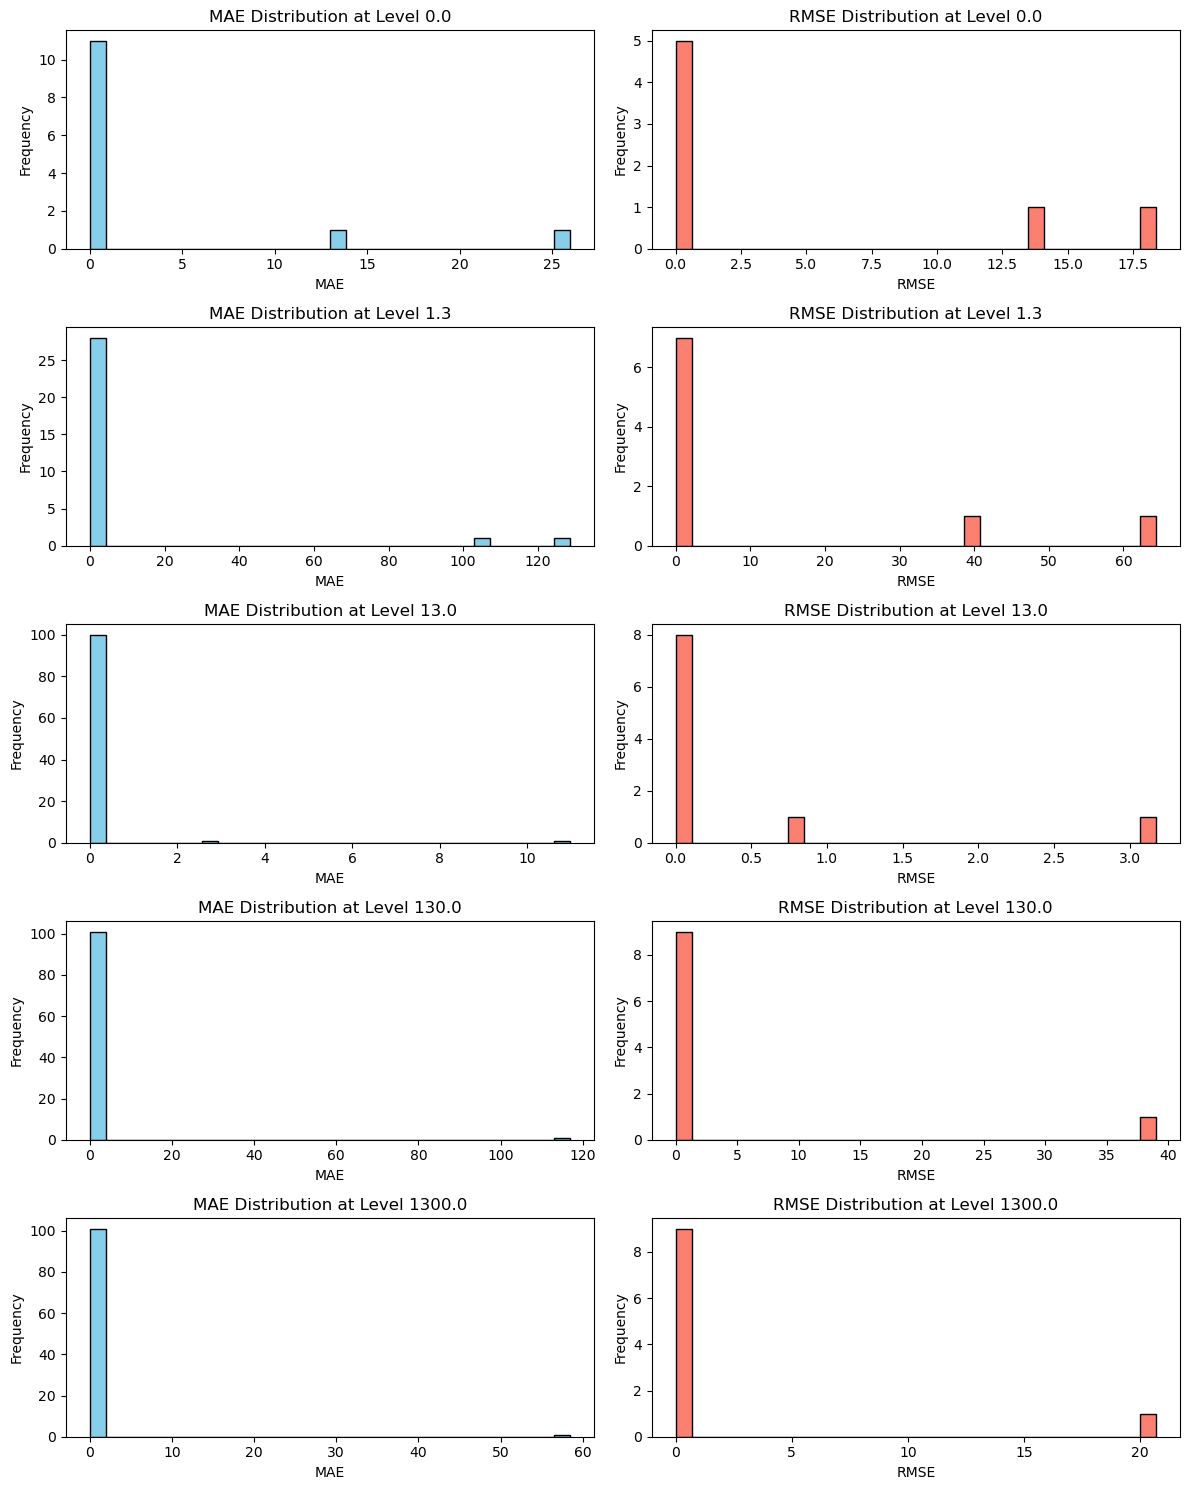

Average Test Metrics:
R2: 0.9995556540391201
RMSE: 6.214332006940173
MAE: 1.3305205042016808
Metrics for Level 0.0:
  RMSE: 4.6161658695944405
  MAE: 3.0820000000000003
Metrics for Level 1.3:
  RMSE: 11.717386372420131
  MAE: 7.862400000000003
Metrics for Level 13.0:
  RMSE: 0.3966058089621204
  MAE: 0.13930392156862748
Metrics for Level 130.0:
  RMSE: 3.9
  MAE: 1.1470588235294117
Metrics for Level 1300.0:
  RMSE: 2.0682873349706514
  MAE: 0.5735294117647058
Top 10 Feature Importances:
1346.64: 0.1290
1371.99: 0.1033
1349.76: 0.1022
1325.22: 0.0863
1278.72: 0.0833
1284.35: 0.0774
1362.38: 0.0734
1334.32: 0.0705
1695.05: 0.0662
1295.77: 0.0506


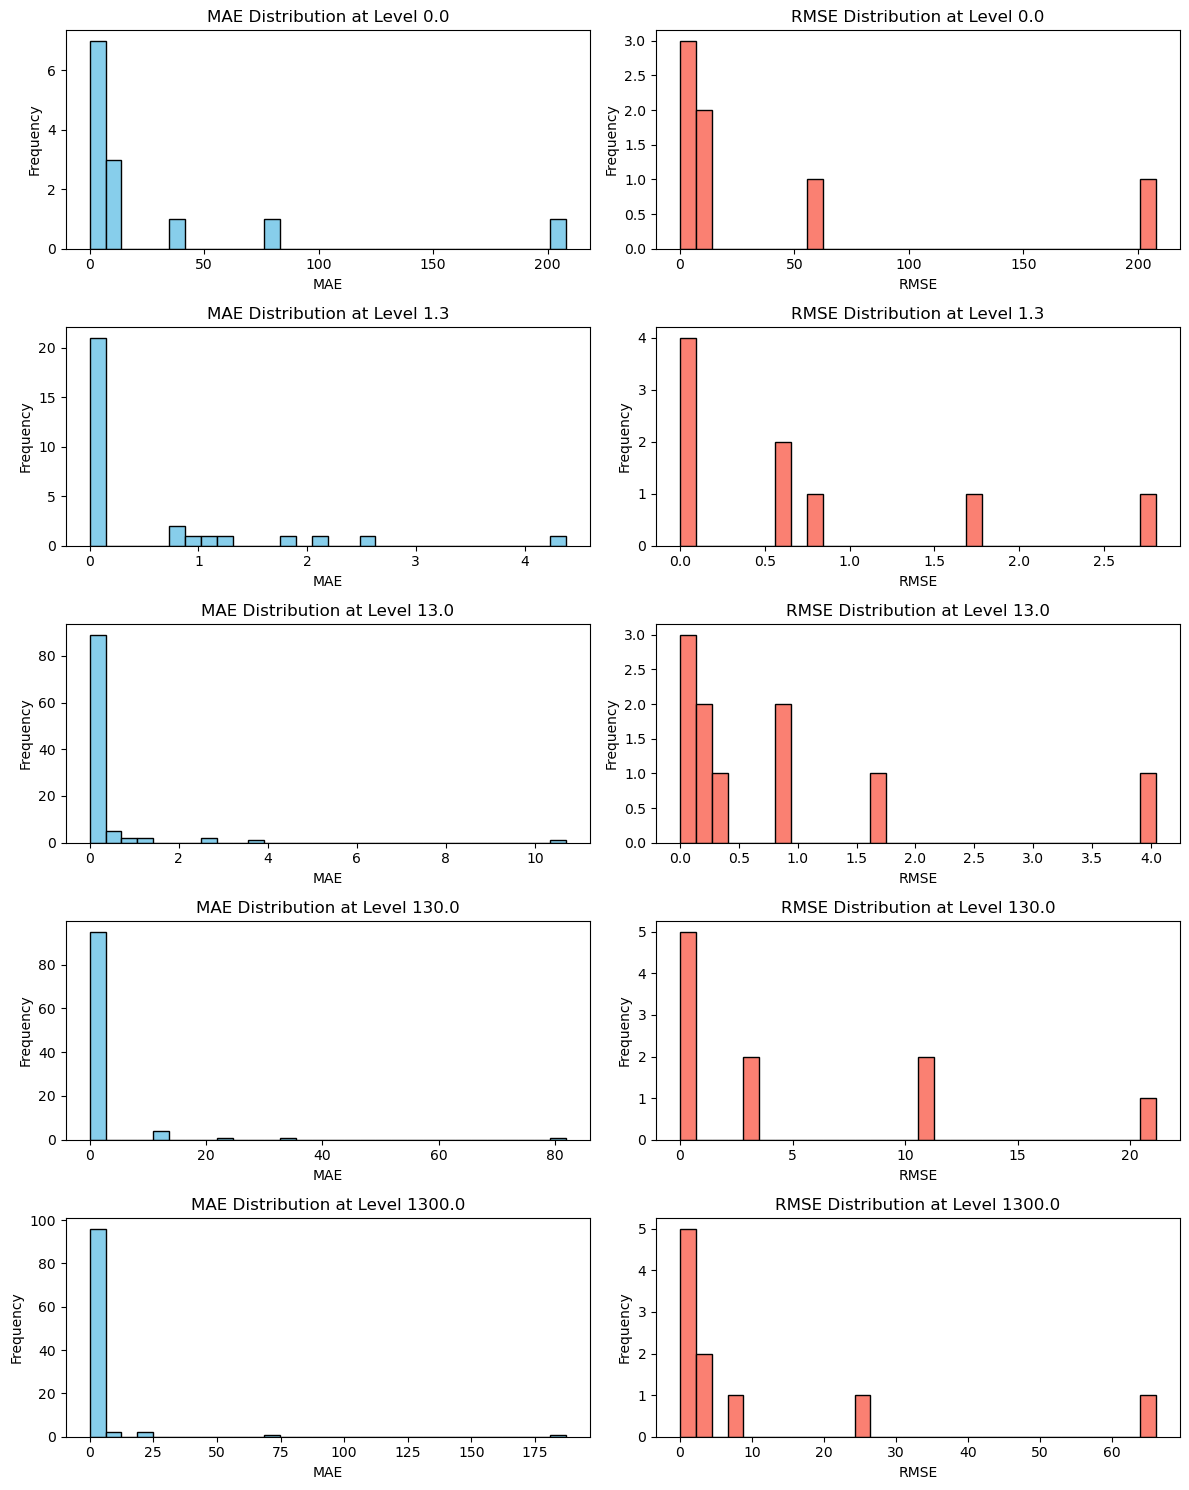

Average Test Metrics:
R2: 0.9989912715431559
RMSE: 11.307272729398749
MAE: 2.6492721848739507
Metrics for Level 0.0:
  RMSE: 41.741953077068004
  MAE: 28.241999999999997
Metrics for Level 1.3:
  RMSE: 0.7381812530230604
  MAE: 0.5442666666666687
Metrics for Level 13.0:
  RMSE: 0.8171530755020295
  MAE: 0.2758039215686276
Metrics for Level 130.0:
  RMSE: 4.901212441812864
  MAE: 1.8352941176470585
Metrics for Level 1300.0:
  RMSE: 10.724520425808809
  MAE: 3.2117647058823566
Top 10 Feature Importances:
1343.54: 0.1101
1601.91: 0.0933
1567.46: 0.0714
1522.45: 0.0635
1510.61: 0.0575
1606.33: 0.0516
1571.69: 0.0476
1546.68: 0.0466
1615.23: 0.0456
1340.45: 0.0437


In [24]:
importance_data_2 = rand_forest_levels(undersampled_data_2_top_features, importances=True)
importance_data_5 = rand_forest_levels(undersampled_data_5_top_features, importances=True)
importance_data_10 = rand_forest_levels(undersampled_data_10_top_features, importances=True)

### PLS levels comparison

In [25]:
def pls_levels(data, k=10, graph=False, n_components=9):
    X = data[data.columns[2:]]  # Select features starting from 3rd column onwards.
    kf = KFold(n_splits=k, shuffle=True, random_state=4)
    
    # Initialise dictionaries to store metrics and errors
    r2_scores = {}
    rmse_scores = {}
    mae_scores = {}
    
    column = 'Concentration'
    y = data[column]
    levels = sorted(y.unique())
    
    # Initialise metrics tracking
    r2_scores[column] = []
    rmse_scores[column] = []
    mae_scores[column] = []
    
    # Store predictions for final evaluation
    all_y_true = []
    all_y_pred = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Standardise features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit PLS model
        model = PLSRegression(n_components=n_components)
        model.fit(X_train_scaled, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test_scaled).ravel()  # Flatten output for 1D target variable
        
        # Metrics for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scores[column].append(r2)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores[column].append(rmse)
        
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[column].append(mae)
        
        # Accumulate predictions
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
    
    # Plot last fold results if graph is True
    if graph:
        plot_observed_vs_predicted(y_test, y_pred, column)
    
    # Compute and display average metrics
    r2_scores[column] = sum(r2_scores[column]) / len(r2_scores[column])
    rmse_scores[column] = sum(rmse_scores[column]) / len(rmse_scores[column])
    mae_scores[column] = sum(mae_scores[column]) / len(mae_scores[column])
    
    level_error_stats = evaluate_levels(np.array(all_y_true), np.array(all_y_pred), levels)
    
    # Print results
    print("Average Evaluation Metrics:")
    print(f"Column: {column}")
    print(f"R2 Score: {r2_scores[column]:.4f}")
    print(f"RMSE: {rmse_scores[column]:.4f}")
    print(f"MAE: {mae_scores[column]:.4f}")
    
    print("\nErrors by Concentration Level:")
    for level in levels:
        print(f"\nConcentration Level {level}:")
        print(f"  Mean Absolute Error: {level_error_stats[level]['mae']:.4f}")
        print(f"  RMSE: {level_error_stats[level]['rmse']:.4f}")
    
    print('-' * 30)

In [26]:
pls_levels(data_2, n_components= 14)
pls_levels(data_5, n_components= 9)
pls_levels(data_10, n_components= 5)

Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9993
RMSE: 13.7788
MAE: 10.3560

Errors by Concentration Level:

Concentration Level 0.0:
  Mean Absolute Error: 11.8488
  RMSE: 15.7716

Concentration Level 1.3:
  Mean Absolute Error: 9.3292
  RMSE: 12.4196

Concentration Level 13.0:
  Mean Absolute Error: 9.8096
  RMSE: 12.0802

Concentration Level 130.0:
  Mean Absolute Error: 10.5624
  RMSE: 14.0359

Concentration Level 1300.0:
  Mean Absolute Error: 11.1725
  RMSE: 16.2003
------------------------------
Average Evaluation Metrics:
Column: Concentration
R2 Score: 0.9964
RMSE: 31.0724
MAE: 23.8872

Errors by Concentration Level:

Concentration Level 0.0:
  Mean Absolute Error: 19.9959
  RMSE: 26.4684

Concentration Level 1.3:
  Mean Absolute Error: 26.1999
  RMSE: 30.8516

Concentration Level 13.0:
  Mean Absolute Error: 26.8131
  RMSE: 40.1227

Concentration Level 130.0:
  Mean Absolute Error: 25.8413
  RMSE: 30.8033

Concentration Level 1300.0:
  Mean Absolute Error: 1

## Identifying ranges

In [27]:
def find_weighted_center_ranges(wavelength_importances, max_gap):
    # Convert wavelengths to float and sort the list by wavelength values
    wavelength_importances = [(float(wl), imp) for wl, imp in wavelength_importances]
    wavelength_importances.sort(key=lambda x: x[0])

    # Initialise variables to track ranges and calculations
    ranges = []
    # Start of the current range
    start = wavelength_importances[0][0]
    # Weighted sum of wavelengths
    weighted_sum = wavelength_importances[0][1] * wavelength_importances[0][0]
    # Sum of importance values
    total_importance = wavelength_importances[0][1]
    # Counter for wavelengths in the current range
    count = 1
    # Previous wavelength
    prev = start

    # Iterate through sorted wavelength-importance pairs
    for wl, imp in wavelength_importances[1:]:
        # If the current wavelength exceeds the maximum allowed gap from the previous, finalise the current range
        if wl > prev + max_gap:
            # Calculate the weighted center for the current range
            center = weighted_sum / total_importance
            # Append the range to the list
            ranges.append((start, prev, center))
            # Start a new range
            start = wl
            # Reset the weighted sum for the new range
            weighted_sum = wl * imp
            # Reset the total importance for the new range
            total_importance = imp
            # Reset count for the new range
            count = 1
        else:
            # If within the gap, add to the current range
            # Update the weighted sum
            weighted_sum += wl * imp
            # Update the total importance
            total_importance += imp
            # Increment count
            count += 1
        # Update previous wavelength
        prev = wl

    # After the loop, add the last range
    # Calculate the final center
    center = weighted_sum / total_importance
    # Append the final range
    ranges.append((start, prev, center))

    return ranges

In [28]:
dataframes = {
    "Path Length 2": importance_data_2,
    "Path Length 5": importance_data_5,
    "Path Length 10": importance_data_10
}
wavelength_columns = [col for col in data.columns[2::]]

# Iterate through each dataset in the dictionary
for name,df in dataframes.items():
    print('Dataset: ' + name)
    # List to store selected columns based on their importance
    selected_column_indices = []
    # Define the maximum gap between wavelengths for grouping
    ran = 15
    
    # Find weighted center ranges for the current dataset with the specified maximum gap
    ranges = find_weighted_center_ranges(df, ran)
    for start, end, center in ranges:
        print(f"Range: {start}-{end} nm, Center: {center:.2f} nm")
        # Find and store the columns within the identified range
        selected_column_indices.extend(
        [col for col in wavelength_columns if float(col) >= start and float(col) <= end]
        )
    print(selected_column_indices)
    print(len(selected_column_indices))
    
    print('\n')

Dataset: Path Length 2
Range: 1391.64-1411.86 nm, Center: 1398.13 nm
Range: 2135.89-2175.73 nm, Center: 2159.61 nm
[1391.64, 1394.97, 1398.31, 1401.68, 1405.05, 1408.45, 1411.86, 2135.89, 2143.74, 2151.65, 2159.62, 2167.65, 2175.73]
13


Dataset: Path Length 5
Range: 1278.72-1295.77 nm, Center: 1284.50 nm
Range: 1325.22-1371.99 nm, Center: 1346.85 nm
Range: 1695.05-1695.05 nm, Center: 1695.05 nm
[1278.72, 1281.53, 1284.35, 1287.19, 1290.04, 1292.9, 1295.77, 1325.22, 1328.24, 1331.27, 1334.32, 1337.38, 1340.45, 1343.54, 1346.64, 1349.76, 1352.89, 1356.04, 1359.2, 1362.38, 1365.57, 1368.77, 1371.99, 1695.05]
24


Dataset: Path Length 10
Range: 1121.34-1121.34 nm, Center: 1121.34 nm
Range: 1340.45-1346.64 nm, Center: 1343.46 nm
Range: 1362.38-1362.38 nm, Center: 1362.38 nm
Range: 1502.83-1619.71 nm, Center: 1564.97 nm
[1121.34, 1340.45, 1343.54, 1346.64, 1362.38, 1502.83, 1506.71, 1510.61, 1514.54, 1518.48, 1522.45, 1526.43, 1530.44, 1534.47, 1538.51, 1542.58, 1546.68, 1550.79, 1554.92, 1

In [29]:
selected_columns_2 = start_columns + [1391.64, 1394.97, 1398.31, 1401.68, 1405.05, 1408.45, 1411.86, 2135.89, 2143.74, 2151.65, 2159.62, 2167.65, 2175.73]
selected_columns_5 = start_columns + [1278.72, 1281.53, 1284.35, 1287.19, 1290.04, 1292.9, 1295.77, 1325.22, 1328.24, 1331.27, 1334.32, 1337.38, 1340.45, 1343.54, 1346.64, 1349.76, 1352.89, 1356.04, 1359.2, 1362.38, 1365.57, 1368.77, 1371.99, 1695.05]
selected_columns_10 = start_columns + [1121.34, 1340.45, 1343.54, 1346.64, 1362.38, 1502.83, 1506.71, 1510.61, 1514.54, 1518.48, 1522.45, 1526.43, 1530.44, 1534.47, 1538.51, 1542.58, 1546.68, 1550.79, 1554.92, 1559.08, 1563.26, 1567.46, 1571.69, 1575.94, 1580.21, 1584.5, 1588.82, 1593.16, 1597.53, 1601.91, 1606.33, 1610.76, 1615.23, 1619.71]

general_features_2 = undersampled_data_2[selected_columns_2]
general_features_5 = undersampled_data_5[selected_columns_5]
general_features_10 = undersampled_data_10[selected_columns_10]

In [30]:
dataframes = {
    "Path Length 2": general_features_2,
    "Path Length 5": general_features_5,
    "Path Length 10": general_features_10
}

for name,df in dataframes.items():
    print('Dataset: ' + name)
    rand_forest(df)
    print('\n')

Dataset: Path Length 2
Average Test Metrics:
R2: 0.9688771639911143
RMSE: 65.14336118321174
MAE: 13.293320420168067
------------------------------


Dataset: Path Length 5
Average Test Metrics:
R2: 0.9995905792584742
RMSE: 6.123989019149534
MAE: 1.2888942857142862
------------------------------


Dataset: Path Length 10
Average Test Metrics:
R2: 0.9992497332892404
RMSE: 9.97945026127763
MAE: 2.3090993277310936
------------------------------




#### Using the levels on these general ranges

Dataset: Path Length 2


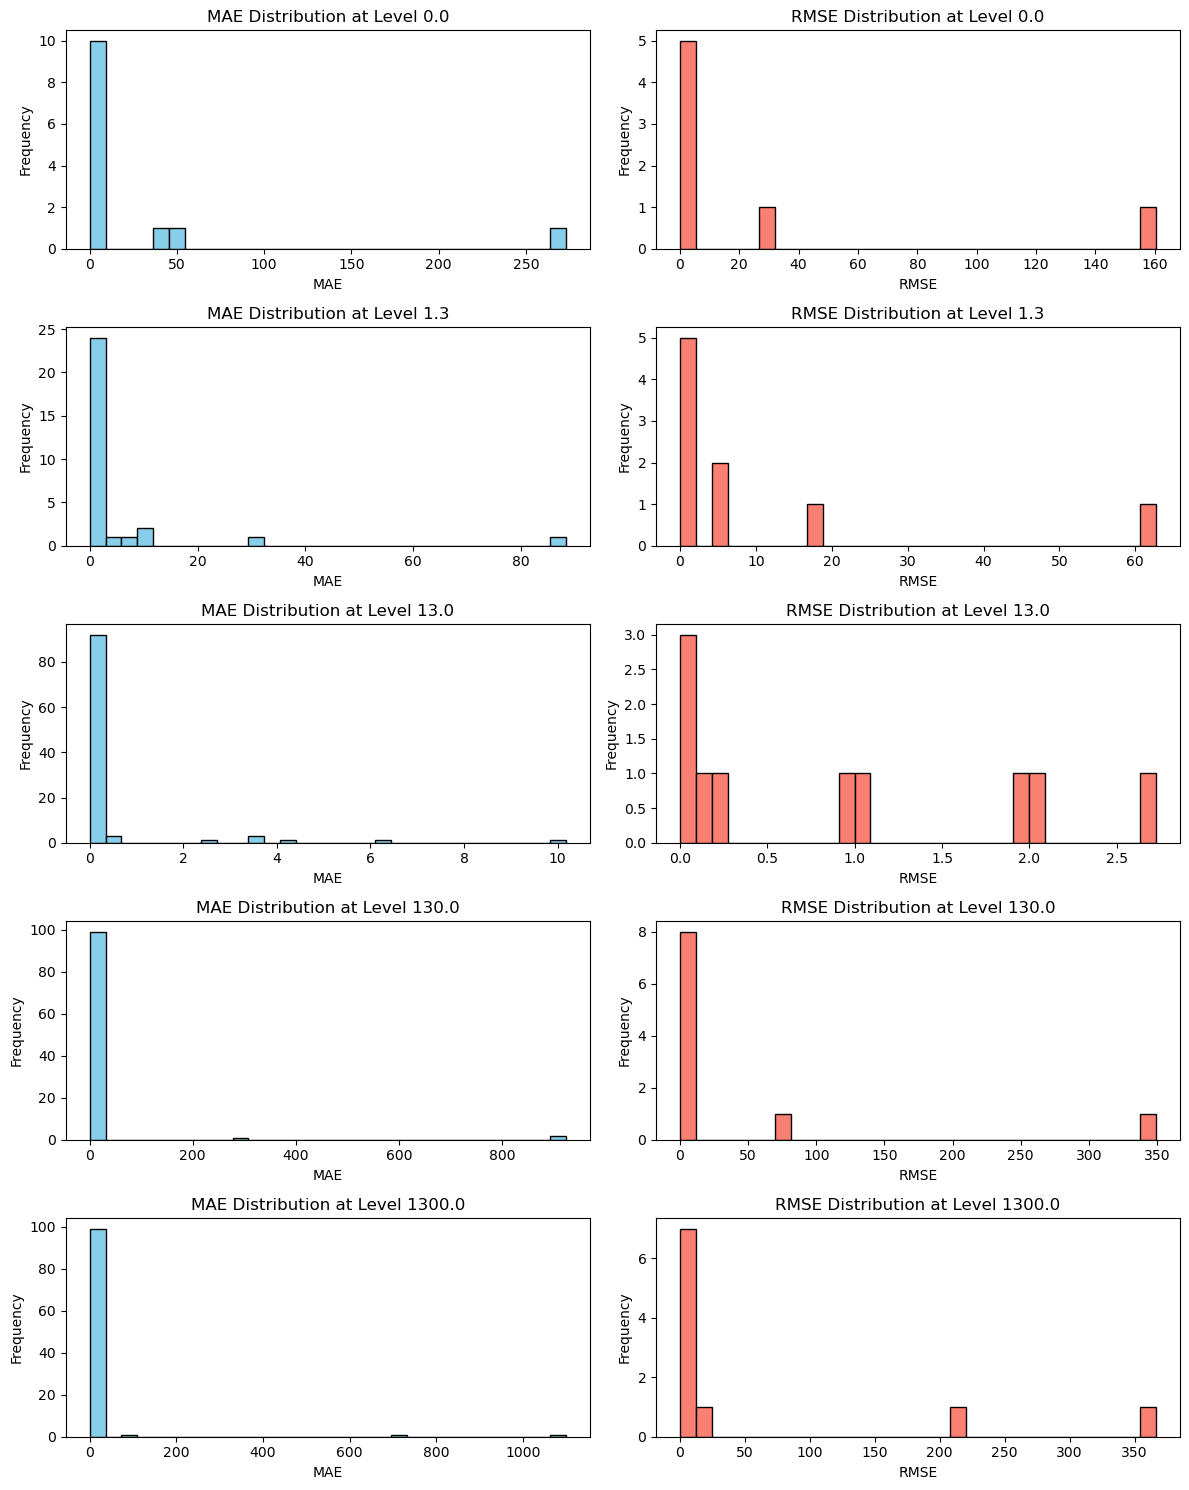

Average Test Metrics:
R2: 0.9688771639911143
RMSE: 65.14336118321174
MAE: 13.293320420168067
Metrics for Level 0.0:
  RMSE: 26.920832825949507
  MAE: 28.057
Metrics for Level 1.3:
  RMSE: 10.094593786735011
  MAE: 5.0882000000000005
Metrics for Level 13.0:
  RMSE: 0.9079082692976286
  MAE: 0.36157843137254936
Metrics for Level 130.0:
  RMSE: 42.87599924497507
  MAE: 21.105882352941173
Metrics for Level 1300.0:
  RMSE: 60.76780919749598
  MAE: 19.041176470588233


Dataset: Path Length 5


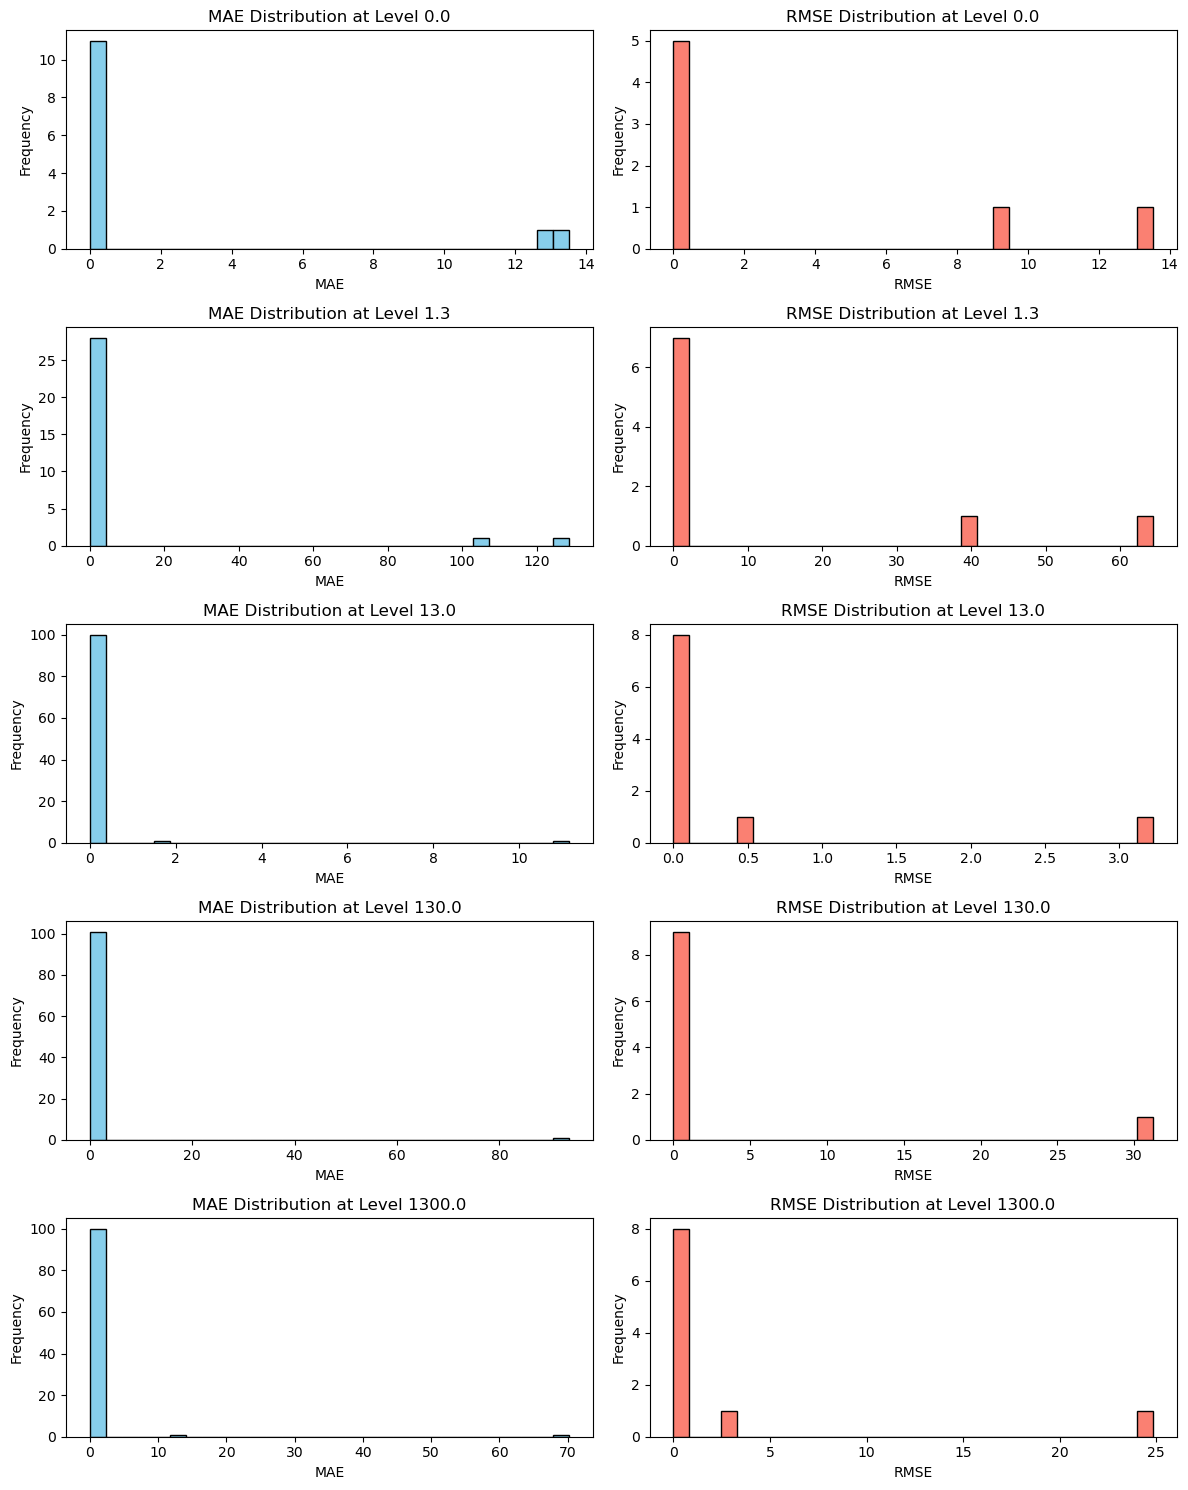

Average Test Metrics:
R2: 0.9995905792584742
RMSE: 6.123989019149534
MAE: 1.2888942857142862
Metrics for Level 0.0:
  RMSE: 3.256204687738283
  MAE: 2.049
Metrics for Level 1.3:
  RMSE: 11.724439185672418
  MAE: 7.864133333333336
Metrics for Level 13.0:
  RMSE: 0.37033504781430543
  MAE: 0.12757843137254904
Metrics for Level 130.0:
  RMSE: 3.12
  MAE: 0.9176470588235294
Metrics for Level 1300.0:
  RMSE: 2.7744448019647843
  MAE: 0.8029411764705892


Dataset: Path Length 10


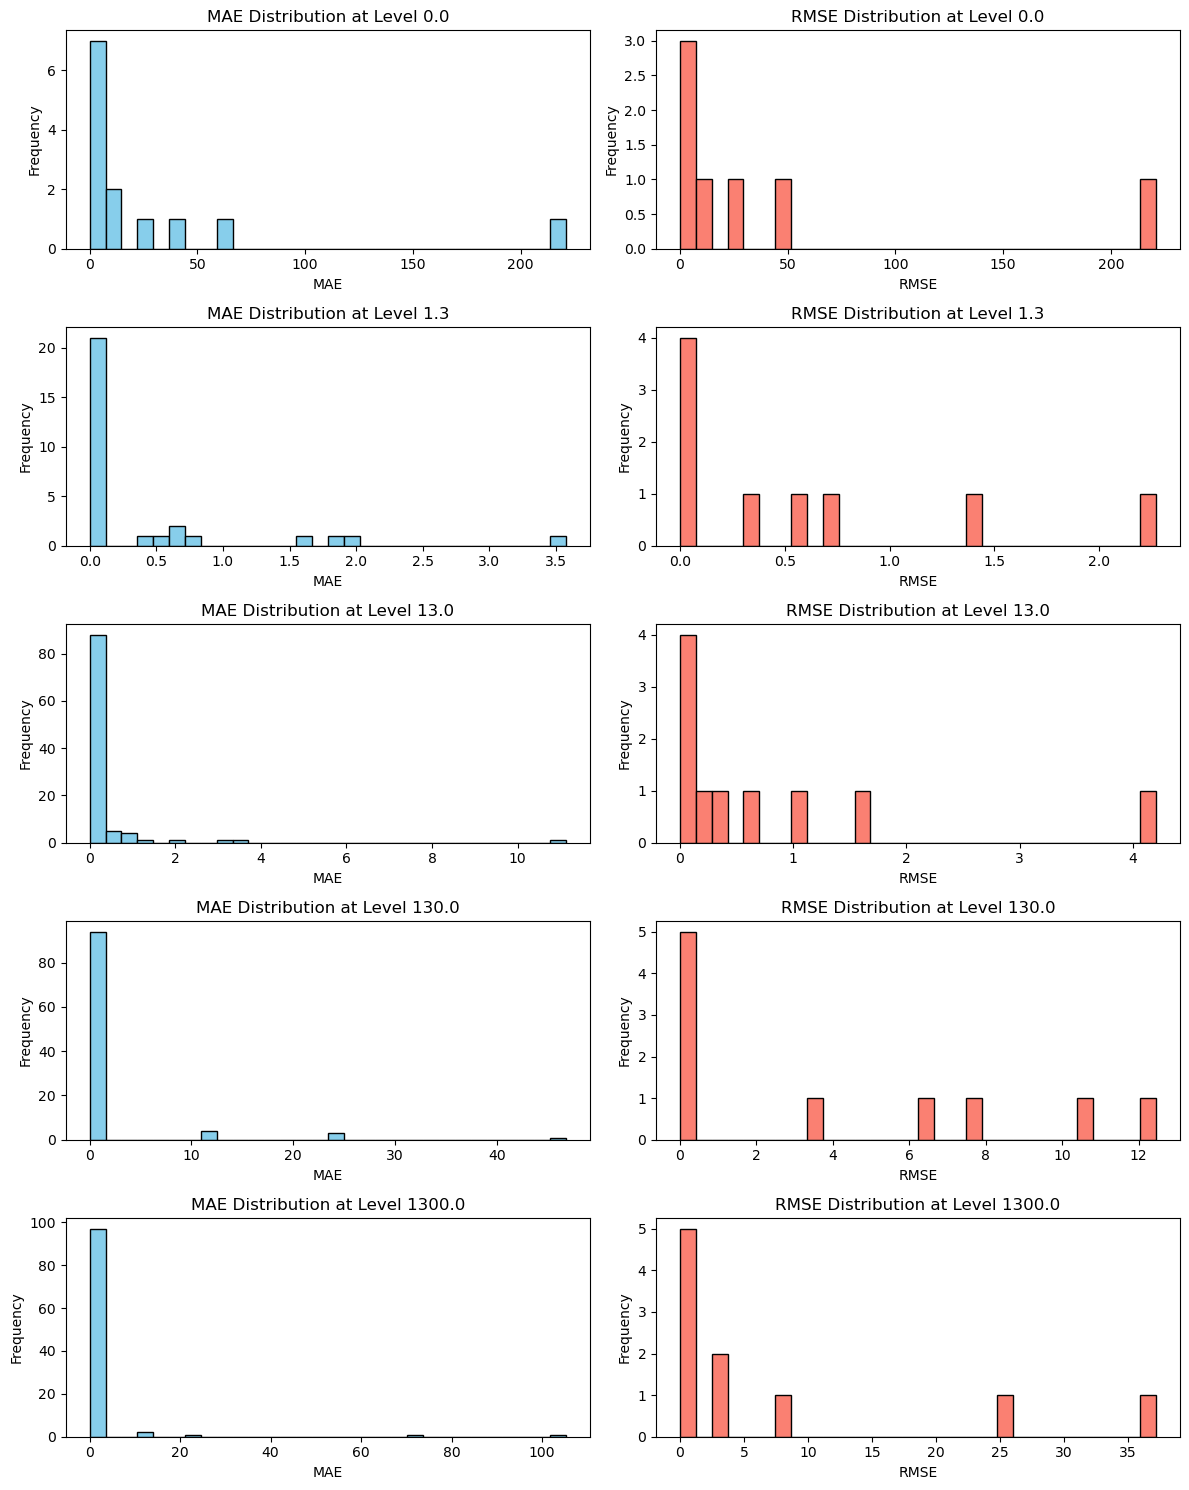

Average Test Metrics:
R2: 0.9992497332892404
RMSE: 9.97945026127763
MAE: 2.3090993277310936
Metrics for Level 0.0:
  RMSE: 43.7856644885071
  MAE: 29.243000000000002
Metrics for Level 1.3:
  RMSE: 0.595309377788029
  MAE: 0.42553333333333526
Metrics for Level 13.0:
  RMSE: 0.8340774663915967
  MAE: 0.2775882352941178
Metrics for Level 130.0:
  RMSE: 4.031992068164887
  MAE: 1.6058823529411763
Metrics for Level 1300.0:
  RMSE: 7.662426846376151
  MAE: 2.179411764705884




In [31]:
dataframes = {
    "Path Length 2": general_features_2,
    "Path Length 5": general_features_5,
    "Path Length 10": general_features_10
}

for name,df in dataframes.items():
    print('Dataset: ' + name)
    rand_forest_levels(df)
    print('\n')

## Shap analysis

In [32]:
def perform_shap_analysis(df, model_params=None, random_state=4):
    if model_params is None:
        model_params = {'random_state': random_state}

    X = df.iloc[:, 2:]
    y = df['Concentration']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)
    
    # Initialise SHAP explainer object on the trained model and training data
    explainer = shap.Explainer(model, X_train)
    # Ensure column names are strings for SHAP
    X_test.columns = X_test.columns.astype(str)
    shap_values = explainer(X_test)

    # Selecting a specific test example to display SHAP force plot
    index = 3
    predicted_value = model.predict(X_test.iloc[index:index+1, :])[0]
    true_value = y_test.iloc[index]

    # Initialise JavaScript visualisation in Jupyter notebook
    shap.initjs()
    # Create a summary dot plot showing the impact of each feature on model output
    shap.summary_plot(shap_values.values, X_test, plot_type="dot")
    
    # Generate SHAP stacked force plot for a specific prediction
    force_plot = shap.force_plot(explainer.expected_value, shap_values.values, X_test)
    
    # Create a waterfall plot for detailed decomposition of a specific prediction
    shap.waterfall_plot(shap_values[index])

    # Display the force plot
    display(force_plot)


    print(f"Predicted y-value for the selected test instance: {predicted_value}")
    print(f"True y-value for the selected test instance: {true_value}")

    return model, explainer

Performing SHAP analysis for: Path Length 10


X has feature names, but RandomForestRegressor was fitted without feature names


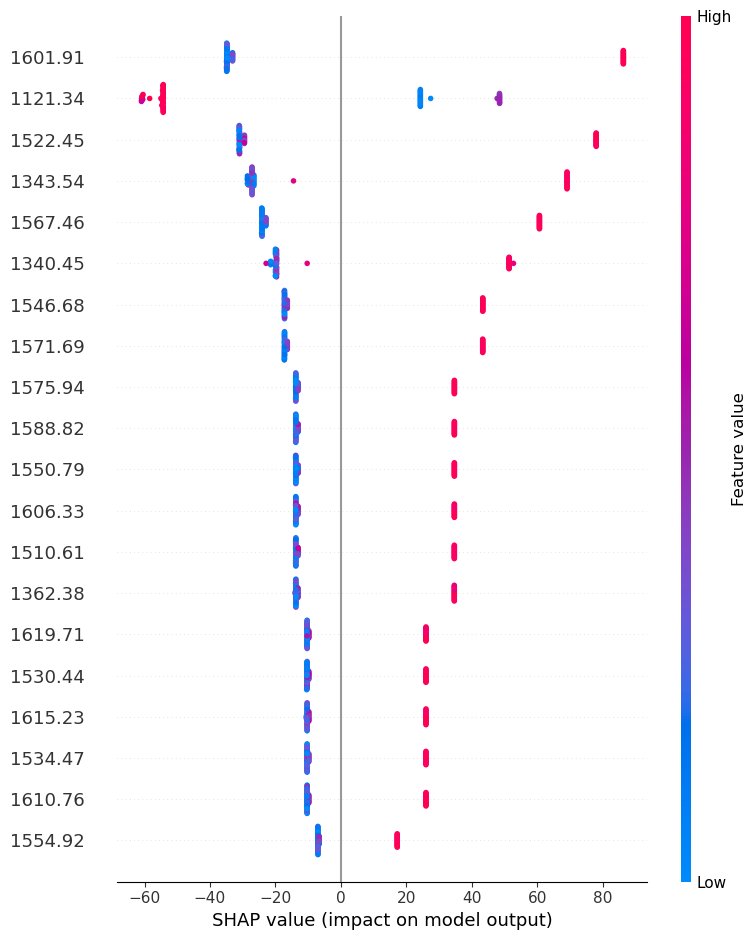

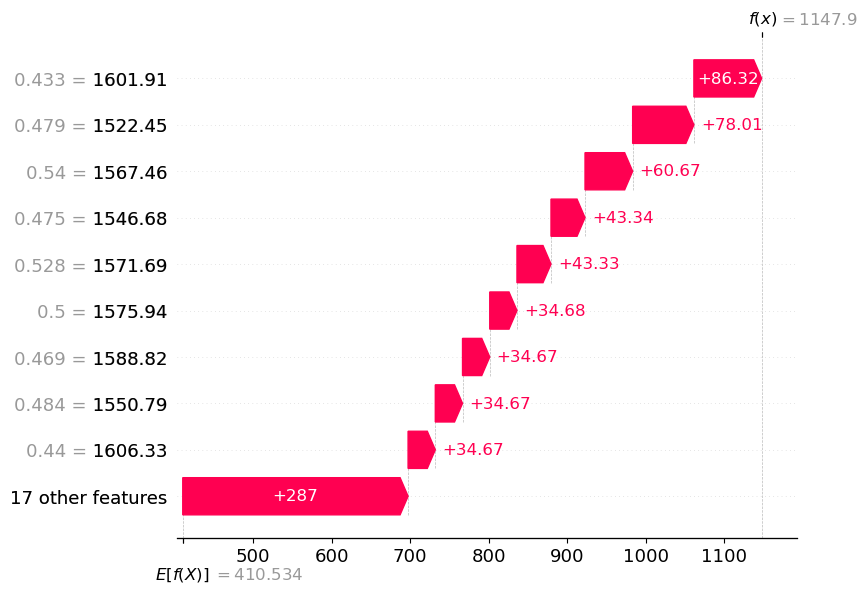

Predicted y-value for the selected test instance: 1147.9
True y-value for the selected test instance: 1300.0


In [33]:
datasets = {
    #"Path Length 2":undersampled_data_2_top_features,
    #"Path Length 5":undersampled_data_5_top_features,
    "Path Length 10":undersampled_data_10_top_features
}

for df_name, df in datasets.items():
    print(f"Performing SHAP analysis for: {df_name}")
    perform_shap_analysis(df)